## Predicting if blood glucose is in target range

Here are what each column represents:

FILL ME

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from io import StringIO
%matplotlib inline

In [9]:
#Get the data
df = pd.read_csv('CareLink-Export-2.csv')

The csv file is formatted such that we have 2 DataFrames (2 sets of column labels and data) one on top of the other. We need to find the index where the second DataFrame begins and create 2 DataFrames.

In [4]:
idx = df[df['Time']=='Sensor'].index
print(idx)

Int64Index([23048], dtype='int64')


In [5]:
df[df['Time']=='Sensor']

,Index,Date,Time,New Device Time,BG Reading (mmol/L),Linked BG Meter ID,Basal Rate (U/h),Temp Basal Amount,Temp Basal Type,Temp Basal Duration (h:mm:ss),...,Scroll Step Size,Insulin Action Curve Time,Sensor Calibration Rejected Reason,Preset Bolus,Bolus Source,Network Device Associated Reason,Network Device Disassociated Reason,Network Device Disconnected Reason,Sensor Exception,Preset Temp Basal Name
23048,-------,MiniMed 670G MMT-1782,Sensor,NG1786171H,-------,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#The first DataFrame
pump = df.iloc[:23047,]

In [7]:
#The second DataFrame
#Ends at 53208-->I know this from looking at the CSV file. To-do: find a better way to id end of file
sensor = df.iloc[23050:53208,]

In [13]:
#sensor.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53434 entries, 0 to 53433
Data columns (total 47 columns):
Index                                  53433 non-null object
Date                                   53433 non-null object
Time                                   53433 non-null object
New Device Time                        9 non-null object
BG Reading (mmol/L)                    2138 non-null object
Linked BG Meter ID                     1 non-null object
Basal Rate (U/h)                       867 non-null object
Temp Basal Amount                      1 non-null object
Temp Basal Type                        1 non-null object
Temp Basal Duration (h:mm:ss)          1 non-null object
Bolus Type                             17647 non-null object
Bolus Volume Selected (U)              17590 non-null object
Bolus Volume Delivered (U)             16726 non-null object
Bolus Duration (h:mm:ss)               1 non-null object
Prime Type                             29 non-null object
Prime 

In [95]:
len(sensor)

30158

In [96]:
#set index to 0
sensor = sensor.reset_index() 

Let's merge the 'Date' and 'Time' columns for each DataFrame and convert them to a datetime object.

In [97]:
def sw(string):
    '''A function to format 'Date' column
    '''
    return '20'+string+' '

In [98]:
pump['Date'] = pump['Date'].apply(sw)

/Users/madeleineanthonisen1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [99]:
sensor['Date'] = sensor['Date'].apply(sw)

In [100]:
pump['datetime'] = pump['Date']+pump['Time']

/Users/madeleineanthonisen1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [101]:
pump['datetime'] = pd.to_datetime(pump['datetime'])

/Users/madeleineanthonisen1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
sensor['datetime'] = sensor['Date']+sensor['Time']

In [103]:
sensor['datetime'] = pd.to_datetime(sensor['datetime'])

In [104]:
#Take the 2 non-null columns and create a new data frame
sensor2 = sensor[['datetime','Sensor Glucose (mmol/L)']]

In [105]:
sensor2.head()

,datetime,Sensor Glucose (mmol/L)
0,2020-03-17 10:57:43,8.27
1,2020-03-17 10:52:43,8.38
2,2020-03-17 10:47:43,8.55
3,2020-03-17 10:42:43,8.66
4,2020-03-17 10:37:43,8.66


In [106]:
#100*pump.isnull().sum()/len(pump)

In [107]:
#drop columns that are entirely null or associated with pump settings I don't use
pump2 = pump.drop(['New Device Time','Index',
       'Linked BG Meter ID','Bolus Duration (h:mm:ss)', 'Prime Type', 'Prime Volume Delivered (U)','Sensor Calibration BG (mmol/L)',
       'Sensor Glucose (mmol/L)', 'ISIG Value', 'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
       'Final Bolus Estimate', 'Scroll Step Size','Sensor Calibration Rejected Reason', 'Preset Bolus', 
       'Network Device Associated Reason',
       'Network Device Disassociated Reason',
       'Network Device Disconnected Reason', 'Sensor Exception',
       'Preset Temp Basal Name'],axis=1)

**Now let's use interval matching to combine columns of sensor with pump.
Ref: https://stackoverflow.com/questions/34880539/pandas-merging-based-on-a-timestamp-which-do-not-match-exactly**

In [108]:
# half-threshold in nanoseconds
threshold = 1
threshold_ns = threshold * 60 * 1e9

# compute "interval" to which each session belongs
sensor2['interval'] = pd.to_datetime(np.round(sensor2.datetime.astype(np.int64) / threshold_ns) * threshold_ns)
pump2['interval'] = pd.to_datetime(np.round(pump2.datetime.astype(np.int64) / threshold_ns) * threshold_ns)

# join
#cols = ['interval', 'BG Reading (mmol/L)', 'Basal Rate (U/h)','Bolus Type','Bolus Volume Selected (U)','Bolus Volume Delivered (U)','Alarm','Suspend','Rewind','BWZ Carb Input (grams)','BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)',
    #   'BWZ Active Insulin (U)','Sensor Glucose (mmol/L)' ]
new = sensor2.merge(pump2, on='interval', how='outer')

/Users/madeleineanthonisen1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [109]:
#new.head()

In [110]:
#new.tail()

In [111]:
len(new)

38984

In [112]:
#new.columns

In [113]:
100*new.isnull().sum()/len(new)

datetime_x                             19.456700
Sensor Glucose (mmol/L)                23.047917
interval                                0.000000
Date                                   40.880874
Time                                   40.880874
BG Reading (mmol/L)                    94.520829
Basal Rate (U/h)                       97.778576
Temp Basal Amount                     100.000000
Temp Basal Type                       100.000000
Temp Basal Duration (h:mm:ss)         100.000000
Bolus Type                             54.735276
Bolus Volume Selected (U)              54.881490
Bolus Volume Delivered (U)             57.097784
Alarm                                  97.850400
Suspend                                99.681921
Rewind                                 99.964088
BWZ Estimate (U)                       97.455366
BWZ Target High BG (mmol/L)            99.797353
BWZ Target Low BG (mmol/L)             99.797353
BWZ Carb Ratio (g/U)                   97.455366
BWZ Insulin Sensitiv

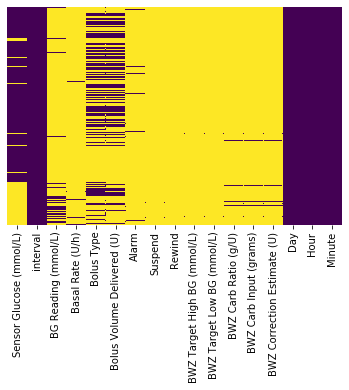

In [60]:
sns.heatmap(new.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [114]:
#drop more columns that are entirely null or associated with pump settings I don't use
new = new.drop(['datetime_x','Date', 'Time','datetime_y'],axis=1)
new = new.drop(['Temp Basal Amount','Temp Basal Type','Temp Basal Duration (h:mm:ss)'],axis=1)
new = new.drop(['Event Marker'],axis=1)
#No idea what this one is--could try to fill it
new = new.drop(['Bolus Number'],axis=1)
new = new.drop('BWZ Food Estimate (U)',axis=1)
new = new.drop('BWZ Active Insulin (U)',axis=1)
#new = new.drop('Bolus Source',axis=1)
#drop columns associated with settings I don't use
new = new.drop('Bolus Volume Selected (U)',axis=1)
#?? could make a better model with these??
new = new.drop(['BWZ Estimate (U)','BWZ BG Input (mmol/L)','Insulin Action Curve Time',
                'BWZ Insulin Sensitivity (mmol/L/U)'],axis=1)

In [115]:
new = new.drop(['BWZ Target High BG (mmol/L)',
       'BWZ Target Low BG (mmol/L)'],axis=1)

In [116]:
#new.dtypes

In [117]:
#Transform numeric columns to float
new['Sensor Glucose (mmol/L)'] = new['Sensor Glucose (mmol/L)'].astype(float)
new['BG Reading (mmol/L)'] = new['BG Reading (mmol/L)'].astype(float)
new['Basal Rate (U/h)'] = new['Basal Rate (U/h)'].astype(float)
#new['Bolus Volume Selected (U)'] = new['Bolus Volume Selected (U)'].astype(float)
new['Bolus Volume Delivered (U)'] = new['Bolus Volume Delivered (U)'].astype(float)
#new['BWZ Estimate (U)'] = new['BWZ Estimate (U)'].astype(float)
#new['BWZ Target High BG (mmol/L)'] = new['BWZ Target High BG (mmol/L)'].astype(float)
new['BWZ Carb Ratio (g/U)'] = new['BWZ Carb Ratio (g/U)'].astype(float)
#new['BWZ Insulin Sensitivity (mmol/L/U)'] = new['BWZ Insulin Sensitivity (mmol/L/U)'].astype(float)
new['BWZ Carb Input (grams)'] = new['BWZ Carb Input (grams)'].astype(float)
#new['BWZ BG Input (mmol/L)'] = new['BWZ BG Input (mmol/L)'].astype(float)
new['BWZ Correction Estimate (U)'] = new[ 'BWZ Correction Estimate (U)'].astype(float)
#new['BWZ Food Estimate (U)'] = new['BWZ Food Estimate (U)'].astype(float)
#new['BWZ Active Insulin (U)'] = new['BWZ Active Insulin (U)'].astype(float)
#new['Bolus Number'] = new['Bolus Number'].astype(float)

In [118]:
#Make new 'Day', 'Hour' and 'Minute' columns
new['Day'] = new['interval'].apply(lambda time: time.day)
new['Hour'] = new['interval'].apply(lambda time: time.hour)
new['Minute'] = new['interval'].apply(lambda time: time.minute)

## Cleaning the data

(15.0, 0.0)

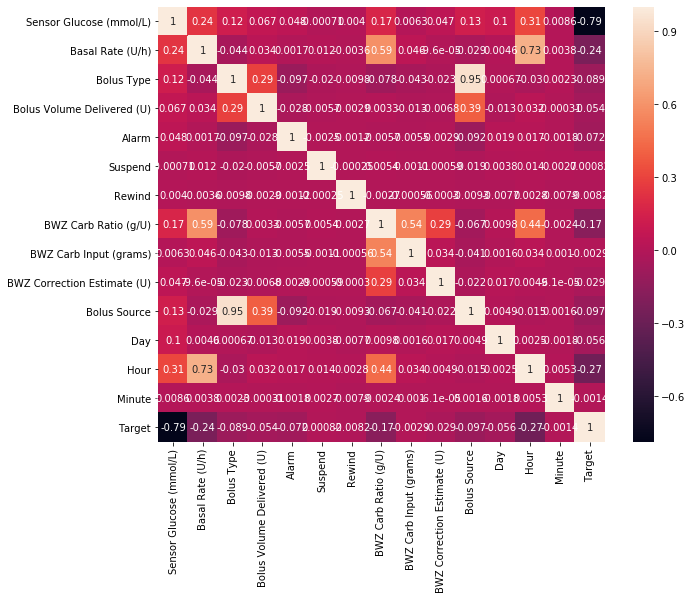

In [149]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(new.corr(),annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

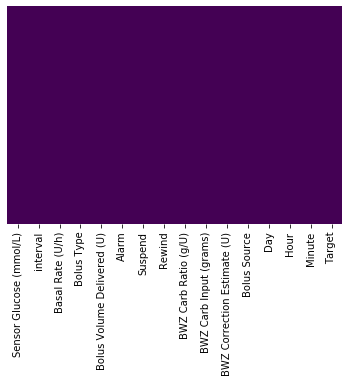

In [148]:
sns.heatmap(new.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [63]:
new.columns

Index(['Sensor Glucose (mmol/L)', 'interval', 'BG Reading (mmol/L)',
       'Basal Rate (U/h)', 'Bolus Type', 'Bolus Volume Delivered (U)', 'Alarm',
       'Suspend', 'Rewind', 'BWZ Target High BG (mmol/L)',
       'BWZ Target Low BG (mmol/L)', 'BWZ Carb Ratio (g/U)',
       'BWZ Carb Input (grams)', 'BWZ Correction Estimate (U)', 'Day', 'Hour',
       'Minute'],
      dtype='object')

'Sensor Glucose (mmol/L)' and 'BG Reading (mmol/L)' represent the same quantity (blood glucose) measured differently

In [120]:
#We want to make a function that replaces null values of 'Sensor Glucose (mmol/L)' with 'BG Reading (mmol/L)' 
#when possible
def bg_replace(cols):
    '''A function to replace null values of 'Sensor Glucose (mmol/L)' 
       with values from 'BG Reading (mmol/L)'
    '''
    sbg = cols[0]
    bgr = cols[1]
    
    if pd.isnull(sbg):
        return bgr
    else:
        return sbg

In [121]:
new['Sensor Glucose (mmol/L)'] = new[['Sensor Glucose (mmol/L)','BG Reading (mmol/L)']].apply(bg_replace,axis=1)

In [122]:
new = new.drop('BG Reading (mmol/L)',axis=1)

'Basal Rate (U/h)': the Basal rate will be the same for a given time interval and currently the only entry in that column indicates a change in the rate. We can fill in some values

In [123]:
#Let's try to make a function to apply to the 'Basal Rate (U/h)' column. 
#I JUST DO IT BY HOUR!!!!!
#TODO: precise to everyhalf hour so do-able read documentation
#A way could be to map interval column eg: df['loan_repaid'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})

def basal_fill(cols):
    '''A function to fill values in 'Basal Rate (U/h)' column. Should be fixed to be able to change on the half hour 
    '''
    num = cols[0]
    hr = cols[1]
    #if num==NaN:
    if pd.isnull(num):
    #if np.isnan(num):
        if hr==0 or hr==1:
            return 0.5
        elif 2<=hr<7:
            return 0.4
        elif 7<=hr<13:
            return 0.7
        elif 13<=hr<15:
            return 0.8
        elif 15<=hr<16:
            return 1.0
        elif 16<=hr<21:
            return 1.6
        elif 21<=hr<22:
            return 0.75
        elif 22<=hr:
            return 0.9
        
    else:
        return num

In [124]:
new['Basal Rate (U/h)'] = new[['Basal Rate (U/h)','Hour']].apply(basal_fill,axis=1)

In [125]:
#Do similar thing as basal for carb ratios
def carb_ratio(cols):
    '''A function to fill values in 'BWZ Carb Ratio (g/U)' column.  
    '''
    num = cols[0]
    hr = cols[1]
    #if num==NaN:
    if pd.isnull(num):
    #if np.isnan(num):
        if hr==0 or hr==1:
            return 9
        elif 1<hr<11:
            return 0
        elif 11<=hr<19:
            return 8.3
        elif 19<=hr:
            return 10
        
    else:
        return num

In [126]:
new['BWZ Carb Ratio (g/U)'] = new[['BWZ Carb Ratio (g/U)','Hour']].apply(basal_fill,axis=1)

Fill NaN values with 0's

In [127]:
new['Bolus Volume Delivered (U)'] = new['Bolus Volume Delivered (U)'].fillna(value=0)

In [128]:
new['BWZ Carb Input (grams)'] = new['BWZ Carb Input (grams)'].fillna(value=0)

In [129]:
new['BWZ Correction Estimate (U)'] = new['BWZ Correction Estimate (U)'].fillna(value=0)

In [130]:
#new['Bolus Number'] = new['Bolus Number'].fillna(value=0)

## Categorical and dummy variables

In [131]:
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38984 entries, 0 to 38983
Data columns (total 15 columns):
Sensor Glucose (mmol/L)        31825 non-null float64
interval                       38984 non-null datetime64[ns]
Basal Rate (U/h)               38984 non-null float64
Bolus Type                     17646 non-null object
Bolus Volume Delivered (U)     38984 non-null float64
Alarm                          838 non-null object
Suspend                        124 non-null object
Rewind                         14 non-null object
BWZ Carb Ratio (g/U)           38984 non-null float64
BWZ Carb Input (grams)         38984 non-null float64
BWZ Correction Estimate (U)    38984 non-null float64
Bolus Source                   17588 non-null object
Day                            38984 non-null int64
Hour                           38984 non-null int64
Minute                         38984 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(3), object(5)
memory usage: 4.8+ MB


In [132]:
new['Bolus Source'].value_counts()

CLOSED_LOOP_MICRO_BOLUS                     15860
CLOSED_LOOP_FOOD_BOLUS                       1054
CLOSED_LOOP_BG_CORRECTION                     462
BOLUS_WIZARD                                  130
CLOSED_LOOP_BG_CORRECTION_AND_FOOD_BOLUS       82
Name: Bolus Source, dtype: int64

In [133]:
#MAYBE DroP SOUrCE!!!
new['Bolus Source'].unique()

array(['CLOSED_LOOP_MICRO_BOLUS', nan, 'CLOSED_LOOP_FOOD_BOLUS',
       'CLOSED_LOOP_BG_CORRECTION', 'BOLUS_WIZARD',
       'CLOSED_LOOP_BG_CORRECTION_AND_FOOD_BOLUS'], dtype=object)

In [134]:
new['Bolus Source'] = new['Bolus Source'].map({'CLOSED_LOOP_MICRO_BOLUS':1,'CLOSED_LOOP_FOOD_BOLUS':2,
                                               'CLOSED_LOOP_BG_CORRECTION':3,'BOLUS_WIZARD':4,
                                               'CLOSED_LOOP_BG_CORRECTION_AND_FOOD_BOLUS':5})

In [135]:
new['Bolus Source'] = new['Bolus Source'].fillna(value=0)

In [136]:
new['Bolus Source'] = new['Bolus Source'].astype(float)

In [140]:
def binit(string):
    '''function to turn string entries to 1 and non-string entries to 0
    '''
    if isinstance(string, str)==True:
        return 1
    else:
        return 0

In [138]:
new['Bolus Type'] = new['Bolus Type'].apply(binit)

In [139]:
new['Alarm'] = new['Alarm'].apply(binit)

In [141]:
new['Suspend'] = new['Suspend'].apply(binit)

In [142]:
new['Rewind'] = new['Rewind'].apply(binit)

In [145]:
#Finally we're ready to drop the NaN's in sensor glucose (even though it should be easy enough to impute the values)
new = new.dropna()

In [146]:
#Let's create a categorical column off the 'Sensor Glucose (mmol/L)' to determine if the BG reading is in target or not
def target(read):
    '''function to create a new 'Target' column based on if 'Sensor Glucose (mmol/L)' is in a range between 4 and 10
    '''
    if 4<=read<=10:
        return 1
    else:
        return 0

In [147]:
new['Target'] = new['Sensor Glucose (mmol/L)'].apply(target)

## Linear Regression

Train and test the data

In [150]:
y = new['Sensor Glucose (mmol/L)']
X = new.drop(['interval','Sensor Glucose (mmol/L)','Target'],axis=1)

In [151]:
from sklearn.model_selection import train_test_split

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [153]:
from sklearn.linear_model import LinearRegression

In [155]:
#create instance of linear regression model
lm = LinearRegression()

In [156]:
#train it on training data
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Predict test data

In [157]:
predictions = lm.predict( X_test)

Text(0, 0.5, 'Predicted Y')

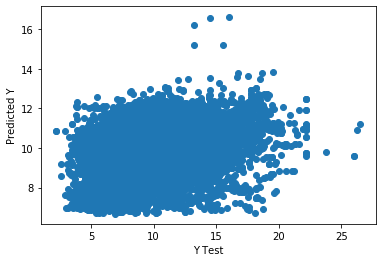

In [158]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

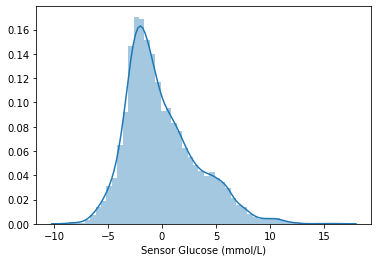

In [159]:
sns.distplot((y_test-predictions),bins=50);

In [160]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 2.6113785773069846
MSE: 10.739739827827897
RMSE: 3.2771542270433196


In [161]:
lm.score(X_test, y_test)

0.13622310062130316

wow not great! let's try other methods

## Logistic Regression

In [162]:
X = new.drop(['Sensor Glucose (mmol/L)','Target','interval'],axis=1)
y = new['Target']

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [164]:
from sklearn.linear_model import LogisticRegression

In [165]:
#create an instance of logistic regression model
lr = LogisticRegression()

In [167]:
lr.fit(X_train,y_train)

/Users/madeleineanthonisen1/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [168]:
predictions = lr.predict(X_test)

In [169]:
from sklearn.metrics import classification_report, confusion_matrix

In [170]:
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[1618 2068]
 [1089 4773]]


              precision    recall  f1-score   support

           0       0.60      0.44      0.51      3686
           1       0.70      0.81      0.75      5862

    accuracy                           0.67      9548
   macro avg       0.65      0.63      0.63      9548
weighted avg       0.66      0.67      0.66      9548



Still not great...!

## K - Nearest Neighbours 

Standardize variables

In [171]:
from sklearn.preprocessing import StandardScaler

In [172]:
#create a standard scaler object
scaler = StandardScaler()

In [173]:
scaler.fit(new.drop(['interval','Target'],axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [174]:
scaled_features = scaler.transform(new.drop(['interval','Target'],axis=1))

In [175]:
new.columns

Index(['Sensor Glucose (mmol/L)', 'interval', 'Basal Rate (U/h)', 'Bolus Type',
       'Bolus Volume Delivered (U)', 'Alarm', 'Suspend', 'Rewind',
       'BWZ Carb Ratio (g/U)', 'BWZ Carb Input (grams)',
       'BWZ Correction Estimate (U)', 'Bolus Source', 'Day', 'Hour', 'Minute',
       'Target'],
      dtype='object')

In [177]:
df_feat = pd.DataFrame(scaled_features,columns=['Sensor Glucose (mmol/L)','Basal Rate (U/h)', 'Bolus Type',
       'Bolus Volume Delivered (U)', 'Alarm', 'Suspend', 'Rewind',
       'BWZ Carb Ratio (g/U)', 'BWZ Carb Input (grams)',
       'BWZ Correction Estimate (U)', 'Bolus Number', 'Day','Hour', 'Minute'])

In [178]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features,new['Target'],
                                                    test_size=0.30)

Use kNN

In [179]:
from sklearn.neighbors import KNeighborsClassifier

In [180]:
knn = KNeighborsClassifier(n_neighbors=1)

In [181]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [182]:
predictions = knn.predict(X_test)

In [183]:
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[3679  173]
 [ 140 5556]]


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3852
           1       0.97      0.98      0.97      5696

    accuracy                           0.97      9548
   macro avg       0.97      0.97      0.97      9548
weighted avg       0.97      0.97      0.97      9548



Much better! can we improve still using kNN?

In [184]:
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

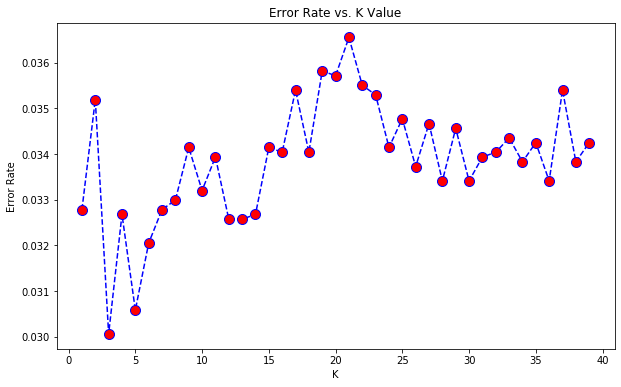

In [185]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [194]:
# NOW WITH K=3
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=3')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=3


[[2258 1428]
 [1314 4548]]


              precision    recall  f1-score   support

           0       0.63      0.61      0.62      3686
           1       0.76      0.78      0.77      5862

    accuracy                           0.71      9548
   macro avg       0.70      0.69      0.70      9548
weighted avg       0.71      0.71      0.71      9548



## Decision Tree

In [196]:
X = new.drop(['Sensor Glucose (mmol/L)','Target','interval'],axis=1)
y = new['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [198]:
from sklearn.tree import DecisionTreeClassifier

In [199]:
dtree = DecisionTreeClassifier()

In [200]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Predict test data

In [201]:
predicitons = dtree.predict(X_test)

In [202]:
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

[[2258 1428]
 [1314 4548]]


              precision    recall  f1-score   support

           0       0.63      0.61      0.62      3686
           1       0.76      0.78      0.77      5862

    accuracy                           0.71      9548
   macro avg       0.70      0.69      0.70      9548
weighted avg       0.71      0.71      0.71      9548



Good not great...

## Random Forest

In [188]:
X = new.drop(['Sensor Glucose (mmol/L)','Target','interval'],axis=1)
y = new['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [189]:
from sklearn.ensemble import RandomForestClassifier

In [190]:
rfc = RandomForestClassifier(n_estimators=600)

In [191]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Predict test data

In [192]:
predictions = rfc.predict(X_test)

In [193]:
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

[[1421 2265]
 [2390 3472]]


              precision    recall  f1-score   support

           0       0.37      0.39      0.38      3686
           1       0.61      0.59      0.60      5862

    accuracy                           0.51      9548
   macro avg       0.49      0.49      0.49      9548
weighted avg       0.52      0.51      0.51      9548



Even worse! more feature-engineering is needed

## Naive Bayes

In [204]:
X = new.drop(['Sensor Glucose (mmol/L)','Target','interval'],axis=1)
y = new['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [205]:
from sklearn.naive_bayes import GaussianNB

In [206]:
bayes = GaussianNB()

In [207]:
bayes.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [208]:
predictions = bayes.predict(X_test)

In [209]:
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

[[2258 1428]
 [1314 4548]]


              precision    recall  f1-score   support

           0       0.63      0.61      0.62      3686
           1       0.76      0.78      0.77      5862

    accuracy                           0.71      9548
   macro avg       0.70      0.69      0.70      9548
weighted avg       0.71      0.71      0.71      9548

